# Exact diagonalization of Bose-Hubbard model - phase diagram

## Introduction

1D [Bose-Hubbard model](https://en.wikipedia.org/wiki/Bose%E2%80%93Hubbard_model) Hamiltonian has a following form:
$$
\hat{H} = -J\sum_i\left(\hat{a}^\dagger_{i+1}\hat{a}_i + h.c.\right) + \frac{U}{2}\sum_i\left(\hat{n}_i-1\right)\hat{n}_i - \mu \sum_i\hat{n}_i
$$
where
- $J$ - hopping integral
- $U$ - on-site interaction
- $\mu$ - chemical potential
- $\hat{a}^\dagger_i$, $\hat{a}_i$, $\hat{n}_i$ - creation, annihilation and particle number operators for site $i$

For large $U$ it describes Mott-insulator, for large $J$ it describes superfluid. 

Bose-Hubbard model conserves number of particles. This means that Hamiltonian matrix is block diagonal with blocks of different total particle number $N=\sum_i n_i$:
$$
\hat{H} = \begin{bmatrix}
& \\
\ddots & \ddots & \ddots & \ddots\\
\dots & 0 & \hat{h}_{N-1}-\mu(N-1) & 0 & \dots \\
 & \dots & 0 & \hat{h}_N-\mu N & 0 & \dots \\
 & & \dots & 0 & \hat{h}_{N+1}-\mu(N+1) & 0 & \dots \\
 & & & \ddots & \ddots & \ddots & \ddots\\
 &
\end{bmatrix}
$$
where
$$
\hat{h}_N = -J\sum_i\left(\hat{a}^\dagger_{i+1}\hat{a}_i + h.c.\right) + \frac{U}{2}\sum_i\left(\hat{n}_i-1\right)\hat{n}_i
$$
acts on a subspace with $N$ particles.

In order to find groundstate of Bose-Hubbard hamiltonian we can do the following:
1. find groundstates $|G_N\rangle$ it's energy $E^{(0)}_N$ of $\hat{h}_N$ matrices with all relevant $N$
2. subtract $\mu N$ from each of them
3. find the smallest value among all $E^{(0)}_N-\mu N$

In the limit of $J=0$ the groundstate is Mott insulator
$$
|\text{MI}_n\rangle = \prod_l\frac{\left(\hat{a}^\dagger_l\right)^n}{\sqrt{n}}|\text{vac}\rangle.
$$
It is characterized by integer number of particles per site $\langle n \rangle$ (the on-site interaction $U$ favors uniform density and penalizes multiple occupations of individual sites). Depending on value of $\mu/U$ it will be different integer - to be precise $\langle n \rangle = \lceil \mu/U \rceil$ ($\lceil x \rceil$ is ceiling function).

The lowest lying excitations in Mott insulator is:
- single particle "on top of" Mott insulator
- or single hole ("one particle less") in Mott insulator

When there are $M$ sites and $N = \langle n\rangle M$ particles in Mott insulator state, these excited states belong to subspace with different particles number - $N+1$ and $N-1$ respectively.

At superfluid-Mott insulator transition the energy gap (energy difference between groundstate and first excited state) becomes $0$. This means that for given $J$ we can find critical value $\mu_c$ using condition for closing of energy gap:
$$
\begin{split}
E_N^{(0)} -\mu N &= E_{N+1}^{(0)} - \mu(N+1)\text{, for particle excitation}\\
E_N^{(0)} -\mu N &= E_{N+1}^{(0)} - \mu(N-1)\text{, for hole excitation}
\end{split}
$$
The solutions to these equations are:
$$
\begin{split}
\mu_c &= E_{N+1}^{(0)} - E_{N}^{(0)}\text{, for particle excitation} \\
\mu_c &= E_N^{(0)} - E_{N-1}^{(0)}\text{, for hole excitiation} 
\end{split}
$$
This means that in order to find line of phase transition between superfluid and Mott insulator with given particle number we need to find only lowest eigenvalue of three $\hat{h}$ matrices with $N$, $N+1$ and $N-1$ for each value of $J$.
In finite systems (finite $M$) this method maybe not accurate in some regions of phase diagram.

As usual we will express all energies in units of $U$ (equivalent to setting $U=1$).

### Implementation
The following uses class `ModelBH` - implementation of exact diagonalization method of Bose-Hubbard model that is based on [Exact diagonalization: the Bose–Hubbard model as an example](https://iopscience.iop.org/article/10.1088/0143-0807/31/3/016) by Zhang and Dong.

I made use of [CuPy](https://docs.cupy.dev/en/stable/) package to perform calculation on GPU. The requirements to run this notebook on GPU are:
1. Nvidia GPU with CUDA
2. Installing CUDA Toolkit - choose correct version [here](https://developer.nvidia.com/cuda-downloads) and follow the instructions

This notebook can also be run on CPU by changing `cupy` to `numpy` and removing `cupyx` from `scipy` imports.

## Imports

In [1]:
from itertools import combinations_with_replacement as cwr
from itertools import product

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import eigsh
from scipy.special import comb
from tqdm import tqdm

## Parametrization

In [2]:
N = 13  # number of particles in Mott state
M = 13  # number of sites

U = 1
J_min = 0
J_max = 0.3
n_J = 50  # number of points along J axis

## `ModelBH` class
For convenience this is implempted in OOP fashion. For detailed explanation of calculation check out my other [notebook](https://github.com/kpatucha/Playground/blob/main/notebooks/BH_exact_diag.ipynb).

In [3]:
# wrapper to free unused GPU memory
def free_gpu_memory(func):
    def wrapper_func(*args, **kwargs):
        retval = func(*args, **kwargs)
        cp._default_memory_pool.free_all_blocks()
        return retval

    return wrapper_func


class ModelBH:
    def __init__(
        self, N: int, M: int, J: float = None, U: float = None, preserve_gs=False
    ):
        self.N = N
        self.M = M
        self.D = comb(self.M, self.N, exact=True, repetition=True)
        self._D_n0 = comb(self.M, self.N - 1, exact=True, repetition=True)

        self._J = J
        self._U = U

        self.basis_states = None

        self._weights = None
        self._tag_eps = None
        self._ind = None
        self._sorted_ind = None
        self._sorted_tags = None

        self.H_kin = None
        self.H_int = None

        self.eigenstates = None
        self.eigenvalues = None
        self._v0 = None
        self.preserve_gs = preserve_gs  # since we usually change J or U only by small amount groundstate is very similar - we can pass previous groundstate to Lanczos algorithm to make convergence faster

        self.f_c = None

    @property
    def J(self):
        return self._J

    @J.setter
    @free_gpu_memory
    def J(self, value):
        if self.preserve_gs and self.eigenstates is not None:
            self._v0 = self.groundstate.copy()  # to start Lanczos with decent vector
        self.eigenstates = None
        self.eigenvalues = None
        self.f_c = None
        self._J = value

    @J.deleter
    def J(self):
        del self.J

    @property
    def U(self):
        return self._U

    @U.setter
    @free_gpu_memory
    def U(self, value):
        if self.preserve_gs and self.eigenstates is not None:
            self._v0 = self.groundstate.copy()
        self.eigenstates = None
        self.eigenvalues = None
        self.f_c = None
        self._U = value

    @U.deleter
    def U(self):
        del self.U

    @property
    def groundstate(self):
        assert self.eigenstates is not None
        return self.eigenstates[:, 0]

    @property
    def groundstate_energy(self):
        assert self.eigenvalues is not None
        return self.eigenvalues[0]

    def tag(self, states):
        return states @ self._weights

    @free_gpu_memory
    def _generate_lookup_table(self):
        self._ind = cp.arange(self.D, dtype=int)
        self._weights = cp.sqrt(100 * cp.arange(1, self.M + 1) + 3)

        basis_tags = self.tag(self.basis_states)
        sorting_idx = cp.argsort(basis_tags)
        self._sorted_tags = basis_tags[sorting_idx]
        self._sorted_ind = self._ind[sorting_idx]
        self._tag_eps = cp.diff(self._sorted_tags).min() / 10

    @free_gpu_memory
    def generate_basis_states(self):
        self.next_site = cp.arange(1, self.M + 1, dtype=int)
        self.next_site[-1] = 0

        self.basis_states = cp.array(
            [
                [multiset.count(m) for m in range(self.M)]
                for multiset in tqdm(cwr(range(self.M), self.N))
            ]
        )

        self._generate_lookup_table()

        self.unit = cp.eye(self.M)
        self.nonzero = (self.basis_states != 0).T

        print("States generated")

    def state_ind(self, states):
        return self._sorted_ind[
            cp.searchsorted(self._sorted_tags, self.tag(states) - self._tag_eps, "left")
        ]

    def hop(self, states, i, j):
        return (
            cp.sqrt((states[:, j] + 1) * states[:, i]),
            states - self.unit[i] + self.unit[j],
        )

    @free_gpu_memory
    def build_hamiltonian(self):
        if self.basis_states is None:
            self.generate_basis_states()

        values = cp.zeros(self._D_n0 * self.M, dtype="float32")
        idx_u = cp.zeros_like(values)
        idx_v = cp.zeros_like(values)

        for i in tqdm(range(self.M)):
            start = i * self._D_n0
            end = (i + 1) * self._D_n0
            coef, states_j = self.hop(
                self.basis_states[self.nonzero[i]], i, self.next_site[i]
            )
            values[start:end] = coef
            idx_u[start:end] = self._ind[self.nonzero[i]]
            idx_v[start:end] = self.state_ind(states_j)

        H_kin = csr_matrix(
            (values, (idx_u, idx_v)), shape=(self.D, self.D), dtype="float32"
        )
        self.H_kin = H_kin + H_kin.T

        self.H_int = 0.5 * csr_matrix(
            (
                (self.basis_states * (self.basis_states - 1))
                .sum(axis=1)
                .astype("float32"),
                (self._ind, self._ind),
            ),
            shape=(self.D, self.D),
        )
        print("Matrices generated")

    @free_gpu_memory
    def diagonalize(self, k=1, **kwargs):
        assert (self.J is not None) and (self.U is not None)
        assert (self.H_kin is not None) and (self.H_int is not None)

        eigsh_config = {"k": k, "v0": self._v0, "which": "SA"}
        eigsh_config.update(**kwargs)
        
        self.eigenvalues, self.eigenstates = eigsh(
            -self.J * self.H_kin + self.U * self.H_int, **eigsh_config
        )

    def density_matrix(self, vec):
        assert self.basis_states is not None
        rho = cp.zeros((self.M, self.M))
        for i, j in product(range(self.M), range(self.M)):
            coef, states_j = self.hop(self.basis_states[self.nonzero[i]], i, j)
            idx = self.state_ind(states_j)
            rho[i, j] = vec[idx] @ (coef * vec[self.nonzero[i]])
        return rho

    def calculate_condensate_fraction(self):
        assert self.groundstate is not None
        rho = self.density_matrix(self.groundstate)
        vals = cp.linalg.eigvalsh(rho)
        self.f_c = vals[0].get() / self.N

## Setup

In [4]:
J_range = cp.linspace(J_min, J_max, num=n_J)
mu_m1_range = cp.zeros_like(J_range)
mu_p1_range = cp.zeros_like(J_range)

print(f"Subspace with N={N} - Mott insulator")
model = ModelBH(N=N, M=M, preserve_gs=True)
model.build_hamiltonian()
model.U = U
print()

print(f"Subspace with N={N-1} - hole excitation")
model_m1 = ModelBH(N=N - 1, M=M, preserve_gs=True)
model_m1.build_hamiltonian()
model_m1.U = U
print()

print(f"Subspace with N={N+1} - particle excitation")
model_p1 = ModelBH(N=N + 1, M=M, preserve_gs=True)
model_p1.build_hamiltonian()
model_p1.U = U

Subspace with N=13 - Mott insulator


5200300it [00:08, 611897.47it/s]


States generated


100%|██████████| 13/13 [00:00<00:00, 28.49it/s]


Matrices generated

Subspace with N=12 - hole excitation


2704156it [00:04, 652452.36it/s]


States generated


100%|██████████| 13/13 [00:00<00:00, 68.06it/s]


Matrices generated

Subspace with N=14 - particle excitation


9657700it [00:16, 578152.11it/s]


States generated


100%|██████████| 13/13 [00:00<00:00, 14.99it/s]


Matrices generated


## Find critical line

In [5]:
for i, J in enumerate(tqdm(J_range)):
    model.J = J
    model_m1.J = J
    model_p1.J = J

    model.diagonalize()
    model_m1.diagonalize()
    model_p1.diagonalize()

    mu_m1_range[i] = model.groundstate_energy - model_m1.groundstate_energy
    mu_p1_range[i] = model_p1.groundstate_energy - model.groundstate_energy

# Transfer to numpy
mu_m1_range = mu_m1_range.get()
mu_p1_range = mu_p1_range.get()
J_range = J_range.get()

100%|██████████| 50/50 [07:46<00:00,  9.33s/it]


## Results
We can compare results to strong coupling expansion by [Freericks and Monien](https://site.physics.georgetown.edu/~jkf/publications/boson_epl_draft_1994.pdf) up to the second order.

In [6]:
# critical line for particle excitation in strong coupling expansion in 2nd order
def mu_p(J, n, U, z=2, e_min=-2):
    return (
        n
        + (n + 1) * J / U * e_min
        - n * (n + 1) * (J / U * e_min) ** 2
        + n * z / 2 * (5 * n + 4) * (J / U) ** 2
    )


# critical line for hole excitiation in strong coupling expansion in 2nd order
def mu_h(J, n, U, z=2, e_min=-2):
    return (
        n
        - 1
        - n * J / U * e_min
        + n * (n + 1) * (J / U * e_min) ** 2
        - (n + 1) * z / 2 * (5 * n + 1) * (J / U) ** 2
    )

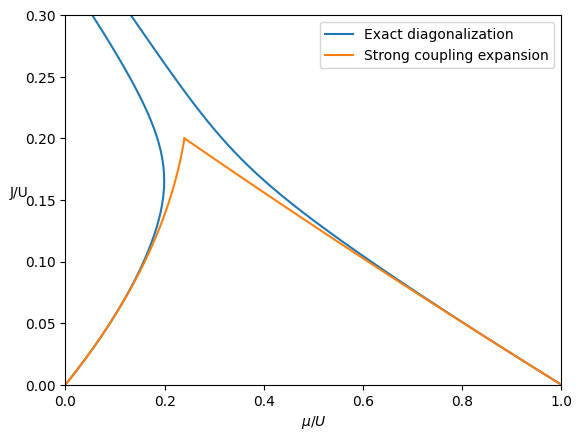

In [7]:
plt.plot(mu_m1_range, J_range, color="C0", label="Exact diagonalization")
plt.plot(mu_p1_range, J_range, color="C0")

J_range_sc = np.linspace(
    0, 0.2, endpoint=True
)  # for strong coupling expansion in 2nd order at J=0.2 both branches meet

plt.plot(
    mu_h(J_range_sc, N / M, U),
    J_range_sc,
    color="C1",
    label="Strong coupling expansion",
)
plt.plot(mu_p(J_range_sc, N / M, U), J_range_sc, color="C1")

plt.xlim(0, 1)
plt.ylim(0, 0.3)
plt.xlabel(r"$\mu/U$")
plt.ylabel(r"J/U", rotation=0)
plt.legend()
plt.show()

Near particle-hole symmetry exact diagonalization for finite system doesn't capture phase transition correctly. This is due to the fact that excitation of a single particle or hole is significant part of the whole system in finite system (aka *not infinitesimally small* as in infinite system). Nevertheless, exact diagonalization correctly captures reentrant behaviour (backwards bend of hole transition line) of 1D Bose-Hubbard model which is not captured by strong coupling expansion in 2nd order.